[6.52812034 5.1945023  4.85142989 3.57844987 3.0475392  2.92772498
 2.52744775 2.37231912 2.16985005 2.02608673 1.83056057]
[1.04370452 1.0567193  1.07440581 1.10587621 1.11822543 1.12608119
 1.14171312 1.1544754  1.17302486 1.18888008 1.22477841]
[6.25475907 4.91568792 4.51545387 3.23585031 2.72533526 2.59992354
 2.21373278 2.05488928 1.84979034 1.70419772 1.49460552]
[1.19162119 1.32763099 1.03956269 1.05574106 1.02626099 0.99907408
 1.01103203 0.98715448 0.97296263 0.96222898 0.95596993]
[0.92226593 0.92004274 0.9275837  0.93032303 0.93396604 0.93491765
 0.93804653 0.94018743 0.94264379 0.94464504 0.94886298]
[1.29205813 1.44301012 1.12072117 1.13481126 1.09882046 1.06862254
 1.07780584 1.04995498 1.03216362 1.01861433 1.00748997]
[0.99142013 1.07623283 0.86276558 0.81061651 0.76069347 0.77888408
 0.77870338 0.78561655 0.79511971 0.78748131 0.7806466 ]
[0.90704665 0.90656227 0.90589539 0.89668021 0.90526094 0.90259017
 0.90568945 0.90474484 0.90545504 0.90357656 0.90214636]
[1.09302

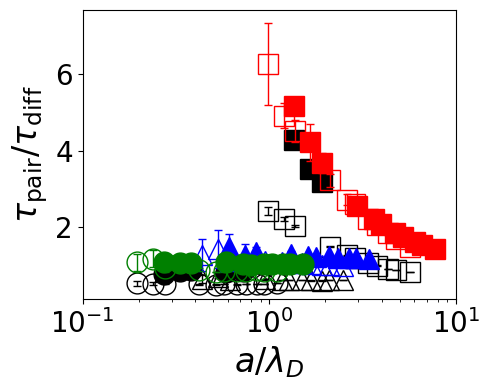

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = "./"

# -------------------
# Load x-data
# -------------------
x_df = pd.read_csv(file_path + "a_lambda_d.csv")

# -------------------
# load Dpp, Dmm (MD or LD)
# -------------------
def load_dpp_dmm(sim_type, eps, model):
    fname = f"{file_path}Diffusion_fit_{sim_type}_{eps}_{model}.csv"
    df = pd.read_csv(fname)

    D_cat = df["Dpp"].values
    D_cat_err = df["Dpp_err"].values
    D_ani = df["Dmm"].values
    D_ani_err = df["Dmm_err"].values

    return D_cat, D_cat_err, D_ani, D_ani_err

# -------------------
# tau_diff
# -------------------
def tau_diff(D_cat, D_ani, err_cat, err_ani, sigma=1.5):
    D_salt = 0.5*(np.array(D_cat) + np.array(D_ani))
    tau = sigma**2/(6*D_salt)

    D_salt_err = np.sqrt((0.5*np.array(err_cat))**2 + (0.5*np.array(err_ani))**2)
    tau_err = (sigma**2/6)*(D_salt_err/D_salt**2)
    return tau, tau_err

# -------------------
# load tau_pair (MD / LD both)
# -------------------
def load_tau_pair(sim_type, eps, model):
    fname = f"{file_path}htfit_params_{sim_type}_{eps}_{model}.csv"
    df = pd.read_csv(fname)
    return df["mean_tau_H"].values, df["mean_tau_H_err"].values

# -------------------
# error propagation for ratio
# -------------------
def ratio_with_err(t1, e1, t2, e2):
    r = t1/t2
    err = np.sqrt((e1/t2)**2 + (t1*e2/t2**2)**2)
    return r, err


# =====================================================
#   MD + LD 계산
# =====================================================

sim_types = ["MD", "LD"]   # NEW
eps_list = ["0.2", "1", "5"]
models = ["LJ", "WCA"]

tau_diff_mean = {}
tau_diff_err = {}
tau_pair = {}
tau_pair_err = {}

for sim in sim_types:
    for eps in eps_list:
        for model in models:

            key = f"{sim}_{eps}_{model}"

            # --- τ_diff from Dpp/Dmm --- #
            Dc, Dc_err, Da, Da_err = load_dpp_dmm(sim, eps, model)
            tau_diff_mean[key], tau_diff_err[key] = tau_diff(Dc, Da, Dc_err, Da_err)

            # --- τ_pair --- #
            tp, tp_err = load_tau_pair(sim, eps, model)
            tau_pair[key] = tp
            tau_pair_err[key] = tp_err


# =====================================================
#   Plot
# =====================================================

color_map_MD = {'0.2':'red','1':'blue','5':'green'}
color_LD = "black"

marker_map = {'0.2':'s','1':'^','5':'o'}

fig, ax = plt.subplots(figsize=(5,4))

for sim in sim_types:
    for eps in eps_list:

        # x-values
        x_lj = x_df[f"{eps}_LJ"].values
        x_wca = x_df[f"{eps}_WCA"].values

        # LJ
        key_lj = f"{sim}_{eps}_LJ"
        r_lj, err_lj = ratio_with_err(
            tau_pair[key_lj], tau_pair_err[key_lj],
            tau_diff_mean[key_lj], tau_diff_err[key_lj]
        )

        # WCA
        key_wca = f"{sim}_{eps}_WCA"
        r_wca, err_wca = ratio_with_err(
            tau_pair[key_wca], tau_pair_err[key_wca],
            tau_diff_mean[key_wca], tau_diff_err[key_wca]
        )
        print(tau_pair[key_wca])
        print(tau_diff_mean[key_wca])
        print(r_wca)
        # ----- 색상 선택 -----
        if sim == "MD":
            color = color_map_MD[eps]
        else:  # LD
            color = color_LD

        # ----- LJ (filled) -----
        ax.errorbar(
            x_lj, r_lj, yerr=err_lj,
            fmt=marker_map[eps],
            color=color,
            mfc=color,           # filled
            mec=color if sim=="MD" else color,
            markersize=15, elinewidth=1, capsize=3,
            label=f"{sim} {eps} LJ", zorder= 100 if sim=="MD" else 1
        )

        # ----- WCA (open) -----
        ax.errorbar(
            x_wca, r_wca, yerr=err_wca,
            fmt=marker_map[eps],
            color=color,
            mfc='none',          # open
            mec=color,
            markersize=15,elinewidth=1, capsize=3,
            alpha=1,
            label=f"{sim} {eps} WCA", zorder= 100 if sim=="MD" else 1
        )


# formatting
ax.set_xscale("log")
ax.set_xlim(0.1, 10)
ax.set_xlabel(r'${a}/{\lambda_D}$', fontsize=24)
ax.set_ylabel(r'$\tau_{\mathrm{pair}}/\tau_{\mathrm{diff}}$', fontsize=24)
ax.tick_params(labelsize=20)

plt.tight_layout()
plt.show()